# A Monte Carlo Approach to Sensitivity Analysis for Multi-Criteria Decision Making
## Lucille E. Nguyen

This document details how to generate a Monte Carlo algorithm to determine the rank-score positions of given engineering/policy alternatives in a hierarchical decision model. Let’s begin with the conditions of a hypothetical engineering decision analysis problem.

Let’s say that three alternatives for a given decision (like the color of a phone) are being evaluated against three attributes of interest. A given scale, like 1 for least feasible and 6 for most feasible, is evaluated for each attribute-alternative pair. For example, if an engineer is evaluating the color to make a phone, and is evaluating the choice “green” against the attribute “cost,” she might give the combination a score of 3 if the color is neither cheap nor expensive. All attribute-alternative pairs in a given comparison table can be considered as an engineering analysis matrix, or A, that does not change.

See an example below of a 3x3 analysis chart.

| **Phone Color** | Cost | Desirability | Delivery |
|-----------------|------|--------------|----------|
|      _Red_      | 1    | 2            | 3        |
|     _Green_     | 3    | 1            | 1        |
|      _Blue_     | 6    | 5            | 6        |

Now, each row of the comparison chart can have all attribute scores added together, multiplied by a given preference weight for each alternative. For example, if cost is the most important attribute, it might get a 50% preference, while desirability and delivery get 25% each. Thus, when you add all fields in a given row, you can rank the outcomes of each potential alternative – like green – against one another.

| Phone Color | Cost | Delivery | Delivery | Total Score | Rank |
|-------------|------|----------|----------|-------------|------|
|   Weights   | 50%  | 25%      | 25%      |             |      |
|     Red     | 1    | 2        | 3        | 1.75        | 3    |
|    Green    | 3    | 1        | 1        | 2           | 2    |
|     Blue    | 6    | 5        | 6        | 5.75        | 1    |

These weights come from a pairwise analysis, determining the importance of each attribute of interest against one another. Using the principles of Thomas L. Saaty (2008)’s work on the Analytic Hierarchy Process, determining these weights comes from a comparison between two attributes taking values between one and nine that must add up to ten. A view of a 3x3 preference matrix generated from a pairwise analysis can be found below:

|              | Cost | Desirability | Delivery |
|--------------|------|--------------|----------|
| Cost         | null | a            | b        |
| Desirability | 10-a | null         | c        |
| Delivery     | 10-b | 10-c         | null     |

This pairwise analysis can generate weights to apply to the engineering analysis matrix **A** by finding the sum of all values for each row and dividing them by all values of the table. For example, the percentage weight to put on the attribute cost would be (a + b) / 30. The value 30 comes from the fact that there are three comparisons (Desirability-Cost, Delivery-Cost, Delivery-Desirability) which must add up to ten each. For simplicity, in the above preference matrix all values to the right of the diagonal that have been highlighted can be multiplied by 10 for the total value of all fields in the table.

Therefore, a possible pairwise matrix to generate weights is below:

|              | Cost | Desirability | Delivery | Total | Weights (Total / 30) |
|--------------|------|--------------|----------|-------|----------------------|
| Cost         | null | 4            | 7        | 11    | 37%                  |
| Desirability | 6    | null         | 2        | 8     | 26%                  |
| Delivery     | 3    | 8            | null     | 11    | 37%                  |

Thus, this pairwise comparison matrix, or B, can be used as a series of weights to be applied to the engineering analysis matrix A. Because there are three comparisons for a decision-maker to evaluate, and each comparison field can take any of nine values between 1-9, there are 9<sup>3</sup> = 729 potential pairwise comparison matrices. However, with more comparison fields, these numbers can quickly become exponentially large.

| Number of Comparison Fields | Potential Matrices |
|-----------------------------|--------------------|
|              5              | 59,049             |
|              10             | 3,486,784,401      |
|              15             | ~206 trillion      |
|              20             | ~12 quintillion    |

While it is possible, with lower numbers of comparisons, to generate all possible pairwise comparison matrices **B** to multiply against engineering analysis matrices **A** to generate total scores and the associated ranks of each alternative, with even small increases in comparisons this becomes computationally intractable. Thus, some method for generating an answer to questions like “Is red consistently ranked last?” or “Is blue always ranked first?” has to be developed that can illustrate the dynamics of the entire space of potential matrix multiplications **A * B**.

Essentially, the process of generating scores by multiplying the engineering analysis against the weights generated by a pairwise comparison matrix is a system of linear equations that can be represented by the following matrix multiplication:

**A * B = Score Matrix**

While it is also potentially possible to come up with a potential score matrix by using the number of attributes under consideration and finding all potential weights that are both 1) possible and 2) add up to 100%, doing so is a subclass of a famously complex problem in combinatorial optimization. That problem, the knapsack problem’s optimization variant, is NP-incomplete and potential solutions generated by an algorithm cannot be verified quickly in polynomial time. Finding an algorithmic solution to a century-old open math problem is deserving of the Abel Prize in mathematics or other awards in theoretical computer science, unfortunately, doing so is beyond the scope of this document.

I have presented a mathematical problem that could require trillions, if not quadrillions of calculations to understand. Even a simpler form of that problem is an unsolved problem in mathematics and optimization, well-deserving of any number of awards should one find a solution to it. Neither of those problems can be solved, at least directly. Let me invoke Edwin Thompson Jaynes in *Probability Theory: The Logic of Science* here:

> “[T]here is a very clever trick for handling a problem that becomes too difficult. We just solve it anyway by:
>1) making it still harder; <br/><br/>
>2) redefining what we mean by ‘solving’ it, so that it comes something we can do; <br/><br/>
>3) inventing a dignified and technical-sounding word to describe this procedure, which has the psychological effect of concealing the true nature of what we have done, and making it appear respectable.”


Fittingly, I have a solution to this problem using an algorithmic Monte Carlo approach. This algorithm will randomly generate a given number of pairwise comparison matrices **B** that can be multiplied by a single engineering analysis matrix **A**, for a result of a number of given **score matrices** (for simplicity, see the earlier equation). This will not find every possible comparison matrix **B**, but instead using random matrix generation, will generate enough random matrices that create a statistically sufficient number of **score matrices** which can represent the entire space of potential outcomes to a reasonable level. Calling this approach “creating a big enough bunch of random numbers and multiplying them to see what happens” is accurate, but let us follow Jaynes’s advice to appear respectable and give it the dignified technical name of Algorithmic Monte Carlo Sensitivity Analysis.

The algorithm must:
1) Generate random, possible pairwise comparison matrices B <br/><br/>
2) Use the weights generated from B to multiply against the engineering analysis matrix A <br/><br/>
3) Solve the system of linear equations represented by A * B to generate score matrices <br/><br/>
4) Use the score matrices to rank each of the alternatives to decide upon <br/><br/>
5) Save the results and repeat the process from step one enough times to create a statistically sufficient sample <br/><br/>
6) Have a halting condition to end the loop after a sufficient sample is reached

The following code fulfills those requirements.

In [1]:
# Import Packages
import random
import numpy as np
import pandas as pd
import itertools
from scipy.stats import rankdata

# Pairwise Comparison Matrix Generator
def random_matrix_generator():
    # In the pairwise matrix, values can be between 1-9
    data = list(range(1, 10))
    
    # There are three rows in the above pairwise comparison. This code populates fields with values between 1-9.
    # For all values on the left of diagonal, their value has been calculated by subtracting populated fields from 10.
    cost_list =  list(np.random.choice(data, size=2))
    desirability_list = list(np.random.choice(data, size=1))
    desirability_list.append(10 - cost_list[0])
    delivery_list = []
    delivery_list.append(10 - cost_list[1])
    delivery_list.append(10 - desirability_list[0])
    
    # This code uses the populated pairwise matrices from above to generate weights to multiply against the engineering matrix.
    weights = [[sum(cost_list) / 30],
               [sum(desirability_list) / 30],
               [sum(delivery_list) / 30]]
    
    # Here, we represent the engineering analysis matrix.
    analysis_matrix = [[1, 2, 3],
                       [3, 1, 1],
                       [6, 5, 6]]
    
    # Using matrix multiplication (dot product), we solve the system of linear equations represented by A * B to generate scores
    # for each potential alternative.
    res = np.dot(analysis_matrix, weights)
    merged = list(itertools.chain(*res))
    
    # Given that each potential alternative now has a score, we can use that score to compare alternatives
    # against one another and rank them in order.
    return(len(merged) - rankdata(merged) + 1)

# Here we create an empty list to store the results of the above function that generates pairwise comparisons, converts them to
# weights, multiplies them against the engineering analysis matrix, gets scores for the various alternatives, and ranks them.
results = []

# We write a quick loop to run the generating function a given number of times, quantified in the runtime variable (250).
def run_results():
    result = random_matrix_generator()
    results.append(result.tolist())
runtime = range(1, 251)
for x in runtime:
    run_results()

Once this code is run, the results list will be populated with the number of randomly generated rankings determined in the runtime variable. In this case, because runtime = range(1, 251), there will be 250 rankings. That amount of random samples is sufficient to evaluate the overall 729 potential rankings with a 95% confidence level and a 5% margin of error.

For simplicity, I used the tidyverse library in the statistical programming language R to visualize the distribution of rankings in the data.

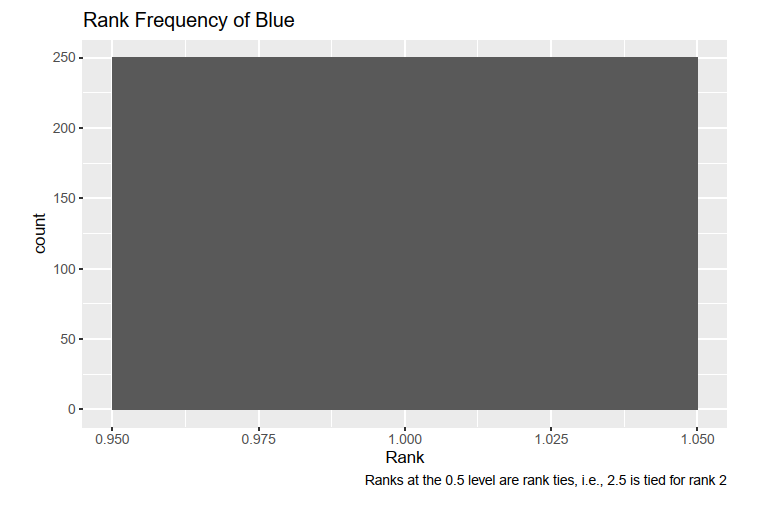

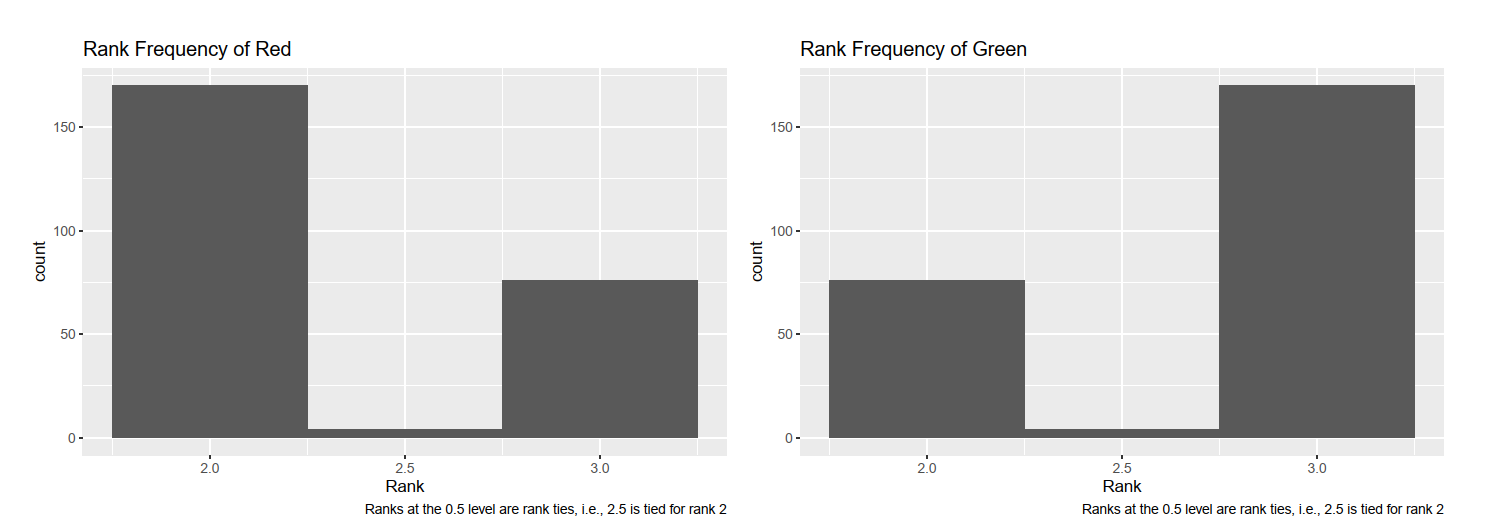

We have created 250 possible random pairwise comparison matrices **B** to generate weights to multiply against a single engineering analysis **A**. From there, we used the dot product of **A * B** to generate scores for each alternative, then used those scores to rank them. A visualization of the data shows a statistically representative snapshot of the data: blue is always first, red is often second, and green is often last.

Using Monte Carlo methods, we have discovered the overall trends in potential ranks each alternative can take. This information can help engineers and stakeholders understand the potential outcomes that changes to the pairwise comparison preference matrix could take. Thus, this algorithmic Monte Carlo approach can serve as one method to the sensitivity analysis problem in multi-criteria decision making models for engineering analysis and operations research.